In [1]:
import numpy as np
import pandas as pd

# 寄付額のシミュレーション

In [7]:
# 会員ステータス
years = ["2014","2015","2016","2017","2018"]
userStatus = ["bronze","silver","gold","inactive"]

# 1000人分のステータスを生成, pは各年の生起確率
userYears = np.random.choice(years,1000,p=[0.1,0.1,0.15,0.30,0.35])
userStats = np.random.choice(userStatus,1000,p=[0.5,0.3,0.1,0.1])
yearJoined = pd.DataFrame({"yearJoined":userYears,"userStats":userStats})
yearJoined.head()

,yearJoined,userStats
0,2017,silver
1,2016,bronze
2,2016,bronze
3,2014,bronze
4,2018,bronze


団体は毎週3回メールを送ることを想定する. 会員は次の三種類の行動パターンをとることを想定する.
- パターン1 : メールを一切開かない
- パターン2 : メール開封率(関与率)が一定
- パターン3 : 関与率に変化がある

In [38]:
NUM_EMAILS_SENT_WEEKLY = 3

# パターン1
def never_opens(period_rng):
    return []

def constant_open_rate(period_rng):
    n,p = NUM_EMAILS_SENT_WEEKLY,np.random.uniform(0,1)
    # 二項分布に従う確率をlen(period_rng)の長さの配列で返す
    num_opened = np.random.binomial(n,p,len(period_rng))
    return num_opened

def increasing_open_rate(period_rng):
    # random.uniform() : 第一引数から第二引数の範囲の乱数を返す
    return open_rate_with_factor_change(period_rng,np.random.uniform(1.01,1.30))

def decreasing_open_rate(period_rng):
    return open_rate_with_factor_change(period_rng,np.random.uniform(0.5,0.99))

def open_rate_with_factor_change(period_rng,fac):
    if len(period_rng)<1:
        return []
    else:
        # np.random.radient() : 第一引数から第二引数の範囲の整数を第三引数のサイズで返す
        times = np.random.randint(0,len(period_rng),int(0.1*len(period_rng)))
        num_opened = np.zeros(len(period_rng))
        # 週3回メールを送るシミュレーション
        for prd in range(0,len(period_rng),2):
            try:
                n,p = NUM_EMAILS_SENT_WEEKLY,np.random.uniform(0,1)
                num_opened[prd:(prd+2)]=np.random.binomial(n,p,2)
            except:
                num_opened[prd] = np.random.binomial(n,p,1)
        for t in range(len(times)):
            num_opened[times[t]] = 0
        return num_opened

次の仮定をもとに寄付行動を定義する.
- 寄付額はユーザーが会員であった期間に依存する
- 各ユーザーの裕福ステータスを生成し, 寄付額は各ユーザーが寄付用に取り分けておいた安定した金額に関係する

In [27]:
# 寄付行動
def produce_donations(period_rng,user_behavior,num_emails,user_id,user_join_year):
    # ユーザーの所持金のリストを定義
    donations_amounts = np.array([0,25,50,70,100,250,500,1000,1500,2000])
    # ユーザーの所持金を生成
    user_has = np.random.choice(donations_amounts)
    email_fraction = num_emails/(NUM_EMAILS_SENT_WEEKLY*len(period_rng))
    # ユーザーの寄付額
    user_gives = user_has*email_fraction
    #ユーザーが寄付できる最大額のインデックスを取得
    user_gives_idx = np.where(user_gives>=donations_amounts)[0][-1]
    user_gives_idx = max(min(user_gives_idx,len(donations_amounts)-2),1)
    num_times_gave = np.random.poisson(2)*(2018-user_join_year)
    # 期間を生成
    times = np.random.randint(0,len(period_rng),num_times_gave)
    dons = pd.DataFrame({"user":[],"amount":[],"timestamp":[]})
    for n in range(num_times_gave):
        donation = donations_amounts[user_gives_idx+np.random.binomial(1,.3)]
        ts = str(period_rng[times[n]].start_time + random_weekly_time_delta())
        dons = dons.append(pd.DataFrame({"user":[user_id],"amount":[donation],"timestamp":[ts]}))
    # 寄付額が0のイベントを削除
    if dons.shape[0]>0:
        dons = dons[dons.amount!=0]
        
    return dons

In [42]:
def random_weekly_time_delta():
    """寄付を行った曜日と時刻を生成する関数
    """
    
    days_of_week = [d for d in range(7)]
    hours_of_day = [h for h in range(11,23)]
    minute_of_hour = [m for m in range(60)]
    second_of_minute = [s for s in range(60)]
    return (pd.Timedelta(str(np.random.choice(days_of_week))+" days")+
           pd.Timedelta(str(np.random.choice(hours_of_day))+" hours")+
           pd.Timedelta(str(np.random.choice(minute_of_hour))+" minute")+
           pd.Timedelta(str(np.random.choice(second_of_minute))+" seconds"))

In [43]:
# シミュレーションの実行
behaviors = [
    never_opens,
    constant_open_rate,
    increasing_open_rate,
    decreasing_open_rate
]
member_behaviors = np.random.choice(behaviors,1000,[0.2,0.5,0.1,0.2])
rng = pd.period_range("2015-02-14","2018-06-01",freq="W")
emails = pd.DataFrame({"member":[],"week":[],"emailsOpened":[]})
donations = pd.DataFrame({"member":[],"amount":[],"timestamp":[]})

for idx in range(yearJoined.shape[0]):
    # 入会した日を生成
    join_date = pd.Timestamp(yearJoined.iloc[idx].yearJoined)+pd.Timedelta(str(np.random.randint(0,365))+" days")
    join_date = min(join_date,pd.Timestamp("2018-06-01"))
    # ユーザーの入会以前のタイムスタンプがあってはいけない
    member_rng = rng[rng.start_time>join_date]
    
    if len(member_rng)<1:
        continue
    info = member_behaviors[idx](member_rng)
    if len(info)==len(member_rng):
        emails = emails.append(pd.DataFrame({
            "member": [idx]*len(info),
            "week" : [str(r.start_time) for r in member_rng],
            "emailsOpened" : info
        }))
        donations = donations.append(produce_donations(member_rng,member_behaviors[idx],sum(info),idx,join_date.year))

<AxesSubplot:xlabel='timestamp'>

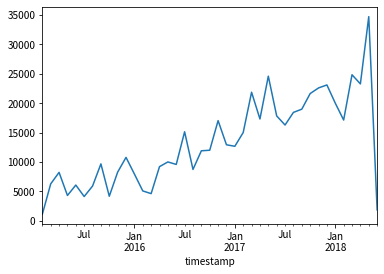

In [48]:
donations.set_index(pd.to_datetime(donations.timestamp),inplace=True)
donations.sort_index(inplace=True)
donations.groupby(pd.Grouper(freq="M")).amount.sum().plot()